In [ ]:
!pip install alpha_vantage
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_curve
import tensorflow as tf
%matplotlib inline

In [2]:
API_KEY = "HTR4BM5GOD0839LD"
stocks = ['META', 'AAPL', 'GOOGL', 'TSLA', "AMD", "AMZN", "NVDA", "JPM", "COST", "TSM"]
df_list = []
for stock in stocks:
    ts = TimeSeries(key=API_KEY, output_format='pandas')
    data = ts.get_daily(symbol=stock, outputsize='full')[0]
    data = data[::-1]
    stock_df = data[['4. close']].rename(columns={'4. close': f'{stock}_close'})
    for i in range(1, 61):
        stock_df[f'{stock}_close_lag_{i}'] = stock_df[f'{stock}_close'].shift(i)
    df_list.append(stock_df)
merged_df = pd.concat(df_list, axis=1, join="inner").dropna()

In [44]:
columns = merged_df.columns
df = pd.DataFrame()
for i in range(60,0,-1):
    current_columns = [column for column in columns if  column.endswith(f'lag_{i}')]
    df[current_columns] = merged_df[current_columns]
for stock in stocks:
    current_columns = [column for column in columns if column.startswith(stock) and column.endswith('close')]
    df[current_columns] = merged_df[current_columns]
for stock in stocks:
    df[f'{stock}_diff'] = df[f'{stock}_close'] - df[f'{stock}_close_lag_1']

df

<ipython-input-44-5b7609aea724>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[current_columns] = merged_df[current_columns]
<ipython-input-44-5b7609aea724>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[current_columns] = merged_df[current_columns]
<ipython-input-44-5b7609aea724>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented

,META_close_lag_60,AAPL_close_lag_60,GOOGL_close_lag_60,TSLA_close_lag_60,AMD_close_lag_60,AMZN_close_lag_60,NVDA_close_lag_60,JPM_close_lag_60,COST_close_lag_60,TSM_close_lag_60,...,META_diff,AAPL_diff,GOOGL_diff,TSLA_diff,AMD_diff,AMZN_diff,NVDA_diff,JPM_diff,COST_diff,TSM_diff
date,,,,,,,,,,,,,,,,,,,,,
2012-08-14,38.2318,530.38,600.40,27.56,6.01,213.85,12.08,33.49,82.94,14.28,...,-1.220,1.69,8.65,-1.75,-0.14,0.75,-0.22,0.11,0.04,0.09
2012-08-15,34.0300,561.28,614.11,28.77,6.30,218.11,12.29,32.51,83.73,14.42,...,0.820,-0.86,-1.12,-0.02,0.07,4.23,-0.11,-0.03,0.80,0.02
2012-08-16,31.0000,556.97,600.80,30.79,6.16,215.33,12.14,34.01,83.38,14.40,...,-1.330,5.51,5.33,0.90,-0.02,4.13,0.30,0.03,0.01,0.03
2012-08-17,32.0000,570.56,609.46,31.02,6.08,217.28,12.44,34.26,83.31,14.08,...,-0.820,11.77,4.27,-0.29,-0.07,-0.38,-0.13,-0.12,-0.34,-0.05
2012-08-20,33.0300,565.32,603.66,30.32,6.02,215.24,12.11,33.97,84.48,13.96,...,0.961,17.04,-1.60,-0.50,-0.01,-0.82,0.00,0.39,-0.12,0.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-18,619.4400,253.48,195.42,479.86,125.02,231.15,130.39,238.36,982.08,200.66,...,-22.540,-1.31,-3.62,-12.70,-1.08,-2.92,-4.10,1.04,-18.56,-3.11
2025-03-19,597.1900,248.05,188.40,440.13,121.41,220.52,128.91,230.37,964.74,195.56,...,1.700,2.55,3.22,10.55,2.72,2.72,2.09,4.14,6.00,0.63
2025-03-20,595.5700,249.79,188.51,436.17,118.88,223.29,130.68,232.96,954.80,194.64,...,1.940,-1.14,-1.09,0.40,0.91,-0.59,1.01,-0.10,-8.65,3.71


In [45]:
X = df.iloc[:,0:600].to_numpy()
y = df.iloc[:,610:].to_numpy()
split_index = int(len(X) * 0.9)
X_train , X_test = X[:split_index] , X[split_index:]
y_train , y_test = y[:split_index] , y[split_index:]
X_train = X_train.reshape(X_train.shape[0], 60, 10)
X_test = X_test.reshape(X_test.shape[0], 60, 10)
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [5]:
model1 = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=True,input_shape = (60, 10)),
    tf.keras.layers.LSTM(64,input_shape = (60, 128)),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(32, activation = 'relu'),
     tf.keras.layers.Dense(16, activation = 'relu'),
    tf.keras.layers.Dense(10)
])
model1.compile(optimizer='adam',loss='mse', metrics=['mae'])
model1.fit(train_ds.batch(32), epochs = 8,validation_data = test_ds.batch(32))
model1.save("model2.keras")
model2 = tf.keras.models.load_model("model2.keras")

Epoch 1/8


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 163ms/step - loss: 224.5714 - mae: 3.4812 - val_loss: 446.2626 - val_mae: 5.1954
Epoch 2/8
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 168ms/step - loss: 224.5280 - mae: 3.4831 - val_loss: 446.2511 - val_mae: 5.1953
Epoch 3/8
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - loss: 224.5365 - mae: 3.4812 - val_loss: 446.2856 - val_mae: 5.1970
Epoch 4/8
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - loss: 224.5424 - mae: 3.4877 - val_loss: 446.2387 - val_mae: 5.1939
Epoch 5/8
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - loss: 224.4760 - mae: 3.4972 - val_loss: 446.2230 - val_mae: 5.1941
Epoch 6/8
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step - loss: 224.4124 - mae: 3.4868 - val_loss: 446.2314 - val_mae: 5.1953
Epoch 7/8
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - loss: 224.4323 - mae: 3.5113 - val_loss: 446.2356 - val_mae: 5.1982
Epoch 8/8
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 224.4360 - mae: 3.4863 - val_loss: 446.2778 - val_mae: 5.2039


In [46]:
y_pred1 = model1.predict(X_test, batch_size=1)
print(f"Naive MAE {mean_absolute_error(y_test, np.zeros_like(y_test))}")
print(f"Model1 MAE {mean_absolute_error(y_test, y_pred1)}")

317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
Naive MAE 5.19344164037855
Model1 MAE 5.203916456250174


In [48]:
backtest1 = pd.DataFrame()

close_col_names = df.iloc[split_index:,590:600].columns
diff_true_col_names = df.iloc[split_index:,610:].columns.map(lambda x : x + '_true')
backtest1[close_col_names] = df.iloc[split_index:,590:600]
backtest1[diff_true_col_names] = df.iloc[split_index:,610:]
signal_true_col_names = diff_true_col_names.map(lambda x : x.replace("_diff", "_signal"))
for i in range(len(signal_true_col_names)):
    backtest1[signal_true_col_names[i]] = backtest1[diff_true_col_names[i]] > 0

diff_pred_col_names = diff_true_col_names.map(lambda x : x.replace("_true", "_pred"))
backtest1[diff_pred_col_names] = y_pred1
signal_pred_col_names = diff_pred_col_names.map(lambda x : x.replace("_diff", "_signal"))
for i in range(len(signal_pred_col_names)):
    backtest1[signal_pred_col_names[i]] = backtest1[diff_pred_col_names[i]] > 0

In [59]:
print(classification_report(backtest1[signal_true_col_names].values.flatten(), backtest1[signal_pred_col_names].values.flatten()))

              precision    recall  f1-score   support

       False       0.45      0.20      0.28      1473
        True       0.53      0.79      0.64      1697

    accuracy                           0.52      3170
   macro avg       0.49      0.50      0.46      3170
weighted avg       0.50      0.52      0.47      3170



In [33]:
initial_cash = 1000
cash = initial_cash
portfolio = {col: 0.0 for col in close_col_names}

for row_index in range(len(backtest1)):

    stock_prices = backtest1.iloc[row_index][close_col_names]
    signals = backtest1.iloc[row_index][signal_pred_col_names]

    investable_cash = cash  # Reset available cash for this round
    num_buy_signals = signals.sum()

    if num_buy_signals > 0:
        weight = 1 / num_buy_signals  # Equal weight for each buy

        for stock, signal in zip(close_col_names, signals):
            price = stock_prices[stock]

            if signal and investable_cash > 0 and price > 0:  # Buy logic
                allocated_cash = weight * investable_cash
                shares_to_buy = allocated_cash / price
                portfolio[stock] += shares_to_buy
                cash -=  shares_to_buy * price  # Prevent negative cash

                # Update investable cash after each buy
                investable_cash = cash

            elif not signal and portfolio[stock] > 0:  # Sell logic
                cash += portfolio[stock] * price  # Sell all holdings
                portfolio[stock] = 0  # Reset holdings



final_prices = backtest1.iloc[-1][close_col_names]
for stock in close_col_names:
    if portfolio[stock] > 0:  # Avoid unnecessary operations
        cash += portfolio[stock] * final_prices[stock]  # Sell remaining stocks
        portfolio[stock] = 0  # Reset portfolio


final_profit = cash - initial_cash
returns = (final_profit / initial_cash) * 100
print(f"Final Cash: ${cash:.2f}")
print(f"Total Profit/Loss: ${final_profit:.2f}")
print(f"Returns: {returns:.2f}%")

Final Cash: $1789.63
Total Profit/Loss: $789.63
Returns: 78.96%


Final Cash: $1789.63
Total Profit/Loss: $789.63
Returns: 78.96%


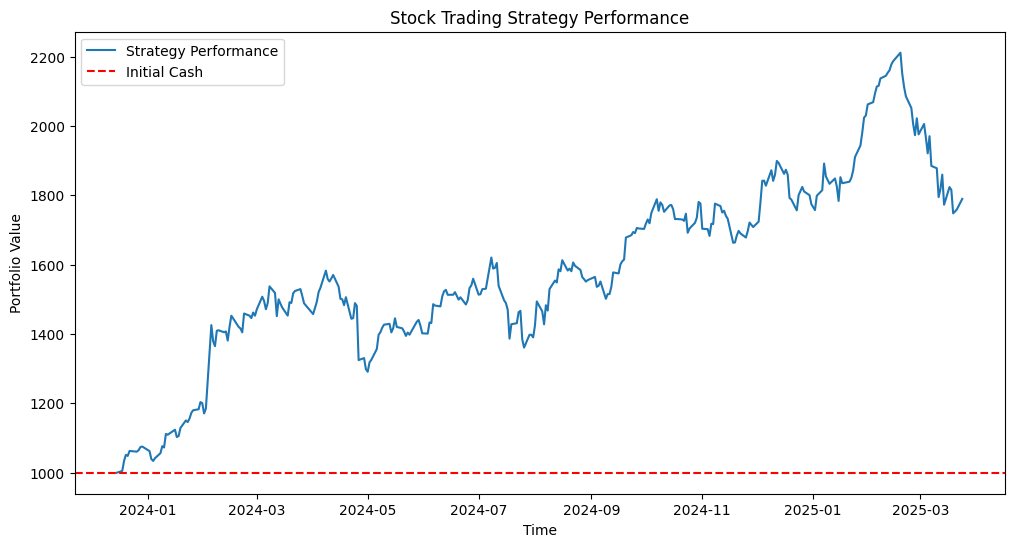

In [29]:
initial_cash = 1000
cash = initial_cash
portfolio = {col: 0.0 for col in close_col_names}
portfolio_values = []

for row_index in range(len(backtest1)):

    stock_prices = backtest1.iloc[row_index][close_col_names]
    signals = backtest1.iloc[row_index][signal_pred_col_names]

    investable_cash = cash  # Reset available cash for this round
    num_buy_signals = signals.sum()

    if num_buy_signals > 0:
        weight = 1 / num_buy_signals  # Equal weight for each buy

        for stock, signal in zip(close_col_names, signals):
            price = stock_prices[stock]

            if signal and investable_cash > 0 and price > 0:  # Buy logic
                allocated_cash = weight * investable_cash
                shares_to_buy = allocated_cash / price
                portfolio[stock] += shares_to_buy
                cash = max(0, cash - shares_to_buy * price)  # Prevent negative cash

                # Update investable cash after each buy
                investable_cash = cash

            elif not signal and portfolio[stock] > 0:  # Sell logic
                cash += portfolio[stock] * price  # Sell all holdings
                portfolio[stock] = 0  # Reset holdings

    # Calculate portfolio value
    stock_value = sum(portfolio[s] * stock_prices[s] for s in close_col_names)
    total_value = cash + stock_value
    portfolio_values.append(total_value)

# **Sell everything at the last available price**
final_prices = backtest1.iloc[-1][close_col_names]
for stock in close_col_names:
    if portfolio[stock] > 0:  # Avoid unnecessary operations
        cash += portfolio[stock] * final_prices[stock]  # Sell remaining stocks
        portfolio[stock] = 0  # Reset portfolio

# **Calculate final profit**
final_profit = cash - initial_cash
returns = (final_profit / initial_cash) * 100

print(f"Final Cash: ${cash:.2f}")
print(f"Total Profit/Loss: ${final_profit:.2f}")
print(f"Returns: {returns:.2f}%")

# **Plot performance**
portfolio_df = pd.DataFrame({"Portfolio Value": portfolio_values}, index=backtest1.index)
plt.figure(figsize=(12, 6))
plt.plot(portfolio_df, label="Strategy Performance")
plt.axhline(initial_cash, color='r', linestyle='--', label="Initial Cash")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.title("Stock Trading Strategy Performance")
plt.show()


Final Cash: $1209.40
Total Profit/Loss: $209.40
Returns: 20.94%


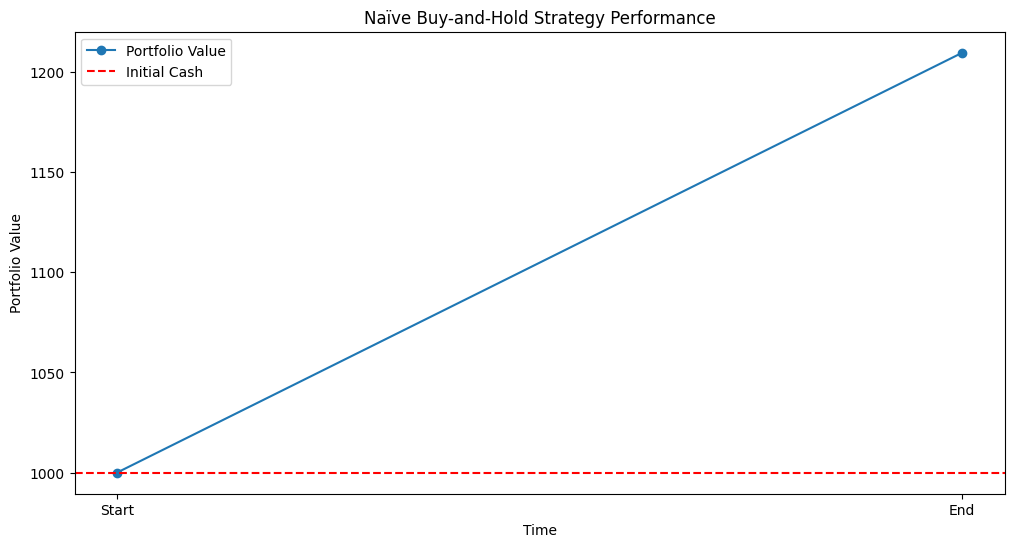

In [26]:
# Initialize capital
initial_cash = 1000
cash = initial_cash

# Get first and last close prices
first_prices = backtest1.iloc[0][close_col_names]
last_prices = backtest1.iloc[-1][close_col_names]

# **1️⃣ Buy all stocks proportionally on the first day**
num_stocks = len(close_col_names)
portfolio = {stock: 0 for stock in close_col_names}

# Equal weight allocation per stock
weight_per_stock = 1 / num_stocks
investable_cash = cash

for stock in close_col_names:
    price = first_prices[stock]
    if price > 0:  # Avoid division errors
        allocated_cash = weight_per_stock * investable_cash
        shares_to_buy = allocated_cash / price
        portfolio[stock] = shares_to_buy
        cash -= shares_to_buy * price  # Deduct cash

# **2️⃣ Hold (No trading in between)**

# **3️⃣ Sell all stocks on the last day**
for stock in close_col_names:
    cash += portfolio[stock] * last_prices[stock]
    portfolio[stock] = 0  # Reset portfolio

# **4️⃣ Calculate final profit & return**
final_profit = cash - initial_cash
returns = (final_profit / initial_cash) * 100

print(f"Final Cash: ${cash:.2f}")
print(f"Total Profit/Loss: ${final_profit:.2f}")
print(f"Returns: {returns:.2f}%")

# **5️⃣ Plot portfolio performance**
portfolio_values = [initial_cash, cash]  # Start and End Values
plt.figure(figsize=(12, 6))
plt.plot(["Start", "End"], portfolio_values, marker="o", linestyle="-", label="Portfolio Value")
plt.axhline(initial_cash, color='r', linestyle='--', label="Initial Cash")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.title("Naïve Buy-and-Hold Strategy Performance")
plt.show()
